In [174]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import json
from decimal import Decimal
from folium import plugins


## Cleaning Data

In [175]:
data = pd.read_csv('data/food-inspections.csv')
data.head()


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2345787,"CARNICERIA LEON GUANAJUATO, INC.","CARNICERIA LEON GUANAJUATO, INC.",1821637.0,Grocery Store,Risk 1 (High),4301-4305 W ARMITAGE AVE,CHICAGO,IL,60639.0,...,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.916960,-87.733945,"{'latitude': '-87.7339453364064', 'longitude':...",NaN,NaN,NaN,NaN,NaN
1,2345790,AMSTAR FUEL & MINI MART,AMSTAR FUEL & MINI MART,1426374.0,Grocery Store,Risk 2 (Medium),3759 W CHICAGO AVE,CHICAGO,IL,60651.0,...,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.895304,-87.721129,"{'latitude': '-87.72112910359348', 'longitude'...",NaN,NaN,NaN,NaN,NaN
2,2345766,ROJO GUSANO,ROJO GUSANO,1305286.0,Restaurant,Risk 1 (High),3830 W LAWRENCE AVE,CHICAGO,IL,60625.0,...,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968390,-87.724448,"{'latitude': '-87.72444785924317', 'longitude'...",NaN,NaN,NaN,NaN,NaN
3,2345702,LAKESIDE FOOD WINE SPIRITS LLC,LAKESIDE FOOD WINE SPIRITS LLC,2694148.0,Grocery Store,Risk 3 (Low),2601 N HALSTED ST,CHICAGO,IL,60614.0,...,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.929210,-87.648746,"{'latitude': '-87.64874626496409', 'longitude'...",NaN,NaN,NaN,NaN,NaN
4,2345678,"NEW KNOWLEDGE LEARNING CENTER, INC.","NEW KNOWLEDGE LEARNING CENTER, INC.",2215898.0,Children's Services Facility,Risk 1 (High),8440 S KEDZIE AVE,CHICAGO,IL,60652.0,...,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.739458,-87.702257,"{'latitude': '-87.70225675980141', 'longitude'...",NaN,NaN,NaN,NaN,NaN


In [375]:
#First we create 3 new columns for time interval of the inspections
data['year']=data['Inspection Date'].apply(lambda x:x.split('-')[0]).astype(int)
data['month']=data['Inspection Date'].apply(lambda x:x.split('-')[1]).astype(int)
data['day']=data['Inspection Date'].apply(lambda x:x.split('-')[2].split('T')[0]).astype(int)

In [376]:
# Let's look in detail to the Zip code 
full_zip = data.groupby("Zip")["Facility Type"].describe()
full_zip.sort_values(by= "count", ascending=True).head(10)

,count,freq,top,unique
Zip,,,,
10014.0,0,NaN,NaN,0
60559.0,0,NaN,NaN,0
60438.0,1,1,Mobile Food Dispenser,1
60423.0,1,1,Shared Kitchen User (Long Term),1
60458.0,1,1,Shared Kitchen User (Long Term),1
60627.0,1,1,AFTER SCHOOL PROGRAM,1
60202.0,1,1,Shared Kitchen User (Long Term),1
60461.0,1,1,Shared Kitchen User (Long Term),1
60464.0,1,1,Shared Kitchen User (Long Term),1


We can see that some Zip codes have to few data's and restaurant we will thus need to do some webscrapping to get the missing information from those Zip codes to include them in our study

In [377]:
print("The number of Zip code in our dataset with less than 5 restaurant is",len(full_zip[full_zip["count"]<=5]))

The number of Zip code in our dataset with less than 5 restaurant is 46


Let's consider only the dataset that contains non NA values for Longitude or Lagitude and we transform the Risk column into an int value column

In [378]:
loc= data[["Latitude","Longitude","AKA Name","Risk"]]
missing = loc[loc.isnull().any(axis = 1)]
data_removed = data.drop(missing.index)
data_removed = data_removed.reset_index()
data_removed["Risk"] = data_removed["Risk"].replace(to_replace =["All"],  
                            value =["Risk 1 (High)"]) 


In [379]:
# Let's look in detail to the Zip code in order to drop those 
restricted_zip = data_removed.groupby("Zip")["Facility Type"].describe()
restricted_zip.sort_values(by= "count", ascending=True).head(4)


,count,freq,top,unique
Zip,,,,
60559.0,0,NaN,NaN,0
60148.0,1,1,Shared Kitchen User (Long Term),1
60406.0,1,1,Shared Kitchen User (Long Term),1
60627.0,1,1,AFTER SCHOOL PROGRAM,1


In [380]:
print("The number of Zip code in our dataset with less than 100 restaurant is",len(restricted_zip[restricted_zip["count"]<100]))
print("The Zip codes are given by",restricted_zip[restricted_zip["count"]<100].index.values)

The number of Zip code in our dataset with less than 100 restaurant is 5
The Zip codes are given by [60148. 60406. 60501. 60559. 60627.]


We can see that after removing the NAN values from our data set, we have that the number of empty zip codes has diminished a lot, for the visualization part, for now we will not consider those Zip in our construction of the mapping of chicago since they do not containg restaurant type facilities in this data.

# B. Exploratory Data Analysis

In this section, we visualize the cleaned data. We make plots centered around variables such as the risk level or the inspections as well as a heatmap to visualize the data geographically.

## B.1 Inspections overview

Here we make 4 plots. The first is a count of the number of inspections by year. The second is a count of the number of inspections by month, using data from all the years. The third plot shows the mean number of inspections depending on the establishment risk level and the fourth is a plot of the count of inspections over the years.

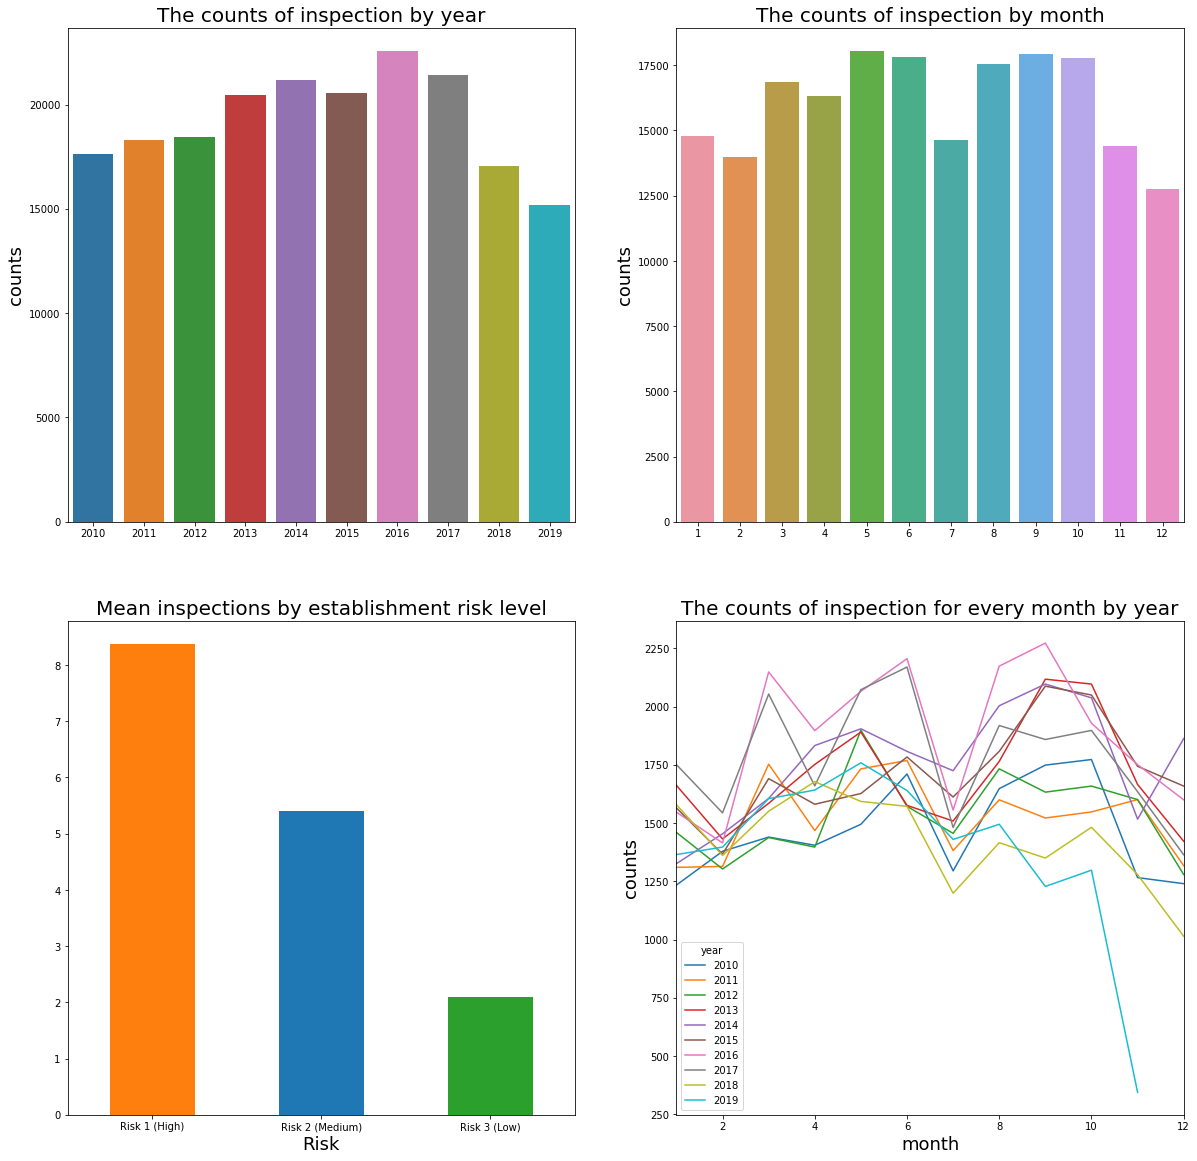

In [381]:
fig,ax=plt.subplots(2,2,figsize=(20,20))
x=data_removed.year.value_counts().index
y=data_removed.year.value_counts()
#Plot 1
sns.barplot(x=x,y=y,ax=ax[0,0])
ax[0,0].set_title("The counts of inspection by year",size=20)
ax[0,0].set_ylabel('counts',size=18)
ax[0,0].set_xlabel('')

x=data_removed.month.value_counts().index
y=data_removed.month.value_counts()
#Plot 2
sns.barplot(x=x,y=y,ax=ax[0,1])
ax[0,1].set_title("The counts of inspection by month",size=20)
ax[0,1].set_ylabel('counts',size=18)
ax[0,1].set_xlabel('')

colors = ['C1','C0','C2']
#Plot 3
mean_inspections = data_removed.groupby(['Risk', 'DBA Name','Latitude','Longitude'])['Inspection ID'].agg('count').unstack('Risk').mean()
mean_inspections.plot(kind='bar', color = colors, ax = ax[1,0])
ax[1,0].set_title("Mean inspections by establishment risk level",size=20)
ax[1,0].tick_params(axis='x',labelrotation=360)
ax[1,0].set_xlabel('Risk', size= 18)

#Plot 4
data_removed.groupby(['year','month'])['Inspection ID'].agg('count').unstack('year').plot(ax=ax[1,1])
ax[1,1].set_title("The counts of inspection for every month by year",size=20)
ax[1,1].set_ylabel('counts',size=18)
ax[1,1].set_xlabel('month',size=18)
plt.show()


The first graph shows a spike in the number of inspections around the year 2016. The second and fourth plots indicate a drop in the inspection rate for the month of July. This drop can be the consequences of workers being on holiday break during the summer.

The third plot indicates that establishments which have had a high risk rating are more likely to be inspected again than those with a lower risk rating. This results is sensible as we expect the inspection authorities to re-investigate an establishment which has a high risk. 

## B.2 Risk overview

Looking at a quick study of the risk we have the following plots. For the first plot the data is grouped by establishment, so as not to count muptiple occurences of the same establishment.

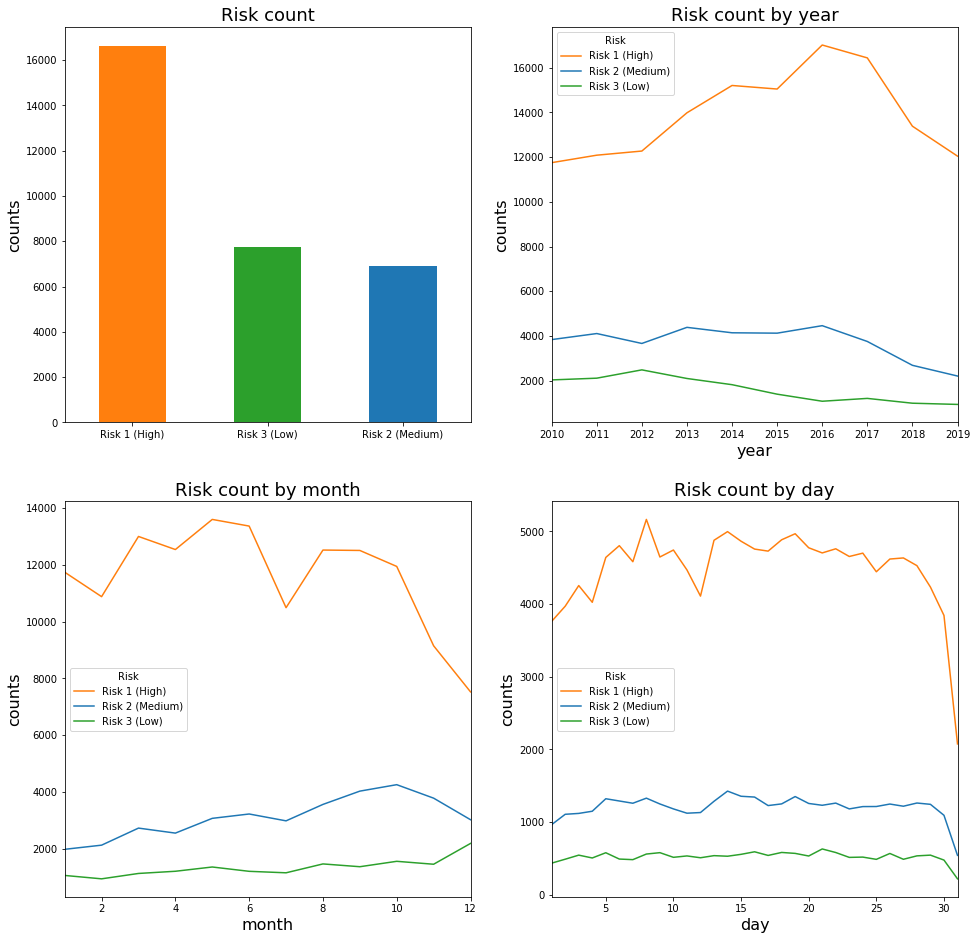

In [383]:
colors = ['C1','C0','C2']
fig,ax=plt.subplots(2,2,figsize=(16,16))
risk_count = data_removed.groupby(['DBA Name','Latitude','Longitude','Risk'])['Inspection ID'].count().to_frame().reset_index()['Risk'].value_counts()
#Plot 1
risk_count.plot(kind = 'bar', color= ['C1','C2','C0'], ax = ax[0,0])
ax[0,0].tick_params(axis='x',labelrotation=360)
ax[0,0].set_title("Risk count",size=18)
ax[0,0].set_ylabel('counts',size=16)

#Plot 2
data_removed.groupby(['year','Risk'])['Inspection ID'].agg('count').unstack('Risk').plot(ax = ax[0,1], color = colors)
ax[0,1].set_title("Risk count by year",size=18)
ax[0,1].set_ylabel('counts',size=16)
ax[0,1].set_xlabel('year',size=16)

#Plot 3
data_removed.groupby(['month','Risk'])['Inspection ID'].agg('count').unstack('Risk').plot(ax = ax[1,0], color = colors)
ax[1,0].set_title("Risk count by month",size=18)
ax[1,0].set_ylabel('counts',size=16)
ax[1,0].set_xlabel('month',size=16)

#Plot 4
data_removed.groupby(['day','Risk'])['Inspection ID'].agg('count').unstack('Risk').plot(ax = ax[1,1], color = colors)
ax[1,1].set_title("Risk count by day",size=18)
ax[1,1].set_ylabel('counts',size=16)
ax[1,1].set_xlabel('day',size=16)

plt.show()

The first plot shows that the vast majority of establishments are considered as high risk while the risk that is less given is Medium Risk.

The second plot shows that the spike of inspections around the year 2016 (described in the previous sub-section) majorly resulted in the count of high risk establishments. The last two plots do not give new insights on the data.

## B.3 Heatmap of the establishments

In [387]:
def generateBaseMap(default_location=coord, default_zoom_start=10):
    """Create a new folium map"""
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [388]:
#Create a data Frame containing each unique restaurant
name_data = data_removed.groupby(["AKA Name","Latitude","Longitude","year"])
#Count the number of inspections by restaurant
name_count = name_data["DBA Name"].count()
name_map = pd.DataFrame(name_count)
name_map = name_map.rename(columns={"DBA Name": "Count"})
name_map = name_map.reset_index()
name_map.head()

,AKA Name,Latitude,Longitude,year,Count
0,"#1 CHINA EXPRESS , LTD",41.816834,-87.631346,2010,1
1,"#1 CHINA EXPRESS , LTD",41.816834,-87.631346,2012,1
2,#1 CHOP SUEY,41.735578,-87.670781,2010,3
3,#1 CHOP SUEY,41.735578,-87.670781,2011,1
4,#1 CHOP SUEY,41.735578,-87.670781,2013,2


In [392]:
from folium.plugins import HeatMap
base_map = generateBaseMap()
HeatMap(data=data_removed[["Latitude","Longitude"]].groupby(["Latitude","Longitude"]).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

The saved map in (...), gives us the exact location of each establishment ploted on the Chicago interactive map. This give us a first insight on the distribution of the establishments in the city. 

# C. Risk Analysis

Here we look more into the risk following two approaches: first we split the city by zip code areas, then we take a look a the data with respect to each risk level.

## C.1 Risk by Zip Code

In [349]:
#We transform this with numerical values as follows
data_removed["Risk"] = data_removed["Risk"].replace(to_replace =["Risk 3 (Low)", "Risk 2 (Medium)", "Risk 1 (High)"],  
                            value =[1,2,3]) 
data_removed.Risk = data_removed.Risk.astype(float)
data_removed["Risk"].value_counts()

3.0    139207
2.0     37424
1.0     16226
Name: Risk, dtype: int64

In [350]:
#Groupby ZIPS
zip_data = data_removed.groupby("Zip")
# Count number of failed exams
failed = data_removed[data_removed['Results'] == 'Fail'].groupby('Zip')["Results"].count()
failed_per = ((failed/zip_data.Results.count())*100)
#Look for most frequent facility 
fac = zip_data["Facility Type"].describe()
#High risk restaurant 
high_risk = data_removed.loc[data_removed['Risk'] == 3]
high_per = ((high_risk["Zip"].value_counts()/data_removed["Zip"].value_counts())*100)
#Low risk restaurant 
low_risk = data_removed.loc[data_removed['Risk'] == 1]
low_per = ((low_risk["Zip"].value_counts()/data_removed["Zip"].value_counts())*100)
#Add interesting features
mean_risk = zip_data.Risk.mean()
value_count = data_removed["Zip"].value_counts()
risk_map = pd.DataFrame(mean_risk)
risk_map["Count"] = value_count
risk_map["Fail"] = failed
risk_map["Percentage of Failed Exams"] = failed_per
risk_map["Percentage High Risk"] = high_per
risk_map["Percentage Low Risk"] = low_per
risk_map["Top Facility"] = fac.top.values
risk_map = risk_map.reset_index()
risk_map["Zip"] = risk_map["Zip"].astype(int)
risk_map = risk_map.fillna(0)
risk_map["Percentage High Risk"] = risk_map["Percentage High Risk"].astype(int)
risk_map["Percentage Low Risk"] = risk_map["Percentage Low Risk"].astype(int)
risk_map["Percentage of Failed Exams"] = risk_map["Percentage of Failed Exams"].astype(int)
risk_map.to_csv("Risk_study.csv")

As we can see the Zip codes defined above should not be considered for explanatory data analysis as they are clear outliers. Hence from the 109 Zips from the beggining we here work only with 60 of those which are mostly composed of restaurants.

We now use Folium to have nice plots with the value of our table defined above.

In [352]:
# load GeoJSON
with open('Boundaries - ZIP Codes.geojson', 'r') as jsonFile:
    data_ = json.load(jsonFile)
tmp = data_

# remove ZIP codes not in our dataset
geozips = []
A=[]
for i in range(len(tmp['features'])):
    A.append(int((tmp['features'][i]['properties']['zip'])))
    if A[i] in (risk_map["Zip"].unique()):
        tmp['features'][i]['properties']['zip'] = int((tmp['features'][i]['properties']['zip']))
        geozips.append(tmp['features'][i])
        
# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save JSON object as updated-file
open("updated-file.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

5939874

We have created a JSON file containing all information needed for our ZIP code that are given in our data and that can be found also in Boundaries - ZIP Codes.geojson. We get a dataset with 61 entries, better to find one with more ZIP 

In [353]:
def create_map(table, zips, mapped_feature, add_text = ''):
    # reading of the updated GeoJSON file
    geo = r'updated-file.json'
    # initiating a Folium map with LA's longitude and latitude
    coord = [data_removed["Latitude"][0],data_removed["Longitude"][0]]
    m = folium.Map(location = coord, tiles='cartodbpositron',zoom_start = 11)
    # creating a choropleth map
    m.choropleth(
        geo_data = geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.zip',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'BuPu',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' Number of facilites ' + add_text + ' Across Chigaco'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = mapped_feature + '_map.html')

In [354]:
# We can thus create maps with all the the features needed 
create_map(risk_map, 'Zip', 'Risk', 'of Facilities')
create_map(risk_map, 'Zip', 'Count', 'of Facilities')
create_map(risk_map, 'Zip', 'Percentage of Failed Exams', 'of Facilities')
create_map(risk_map, 'Zip', "Percentage High Risk", 'of Facilities')
create_map(risk_map, 'Zip', "Percentage Low Risk", 'of Facilities')


/home/red/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


We have now the following results:

In the count map found here (...), we can see that the majority of district have between 1200 and 3500 facilities. We can see that the district with the most facilities are all next to each other and centerd near uptown Chicago. We will now look more in detail which area are given the highest risk and which one actually fails more inspections.

In the Percentage High Risk map found here (...), we can see that the vast majority of districts have between 70-80% of High Risk facilities, we can see that the districts with fewer facilities and further from the upper district of Chicago are also the one with a low percentage of high risk given facilities. Hence we can deduce that it is considered, the residential district have few riskier facilities but less options to eat.

In the Percentage Low Risk map found here (...), we can see that there very few low risk facilities and they are spread evenly across district.

In the Percentage of Failed Exams map found here (...), we might have expected that the district with the highest count of restaurant who also have a percentage of high risk are not the ones with the highest percentage of failed inspections. The ones with the highest percentage of violation are around 30% and situated in the lower district of chicago, which are more residential but poorer districts.

In [355]:
def coloriage(zip_):
    if risk_map.loc[risk_map['Zip'] == zip_, 'Top Facility'].values[0]=="Restaurant":
        return '#0000ff'
    else:
        return '#ff0000'
    

In [356]:
# We want to look at the map where he have the most frequent facility type
state_geo_path = r"updated-file.json"
geo_json_data = json.load(open(state_geo_path))
results_map = folium.Map(coord, tiles='cartodbpositron', zoom_start=10)
folium.GeoJson(
    geo_json_data,
    style_function=lambda features: {
        'fillColor': coloriage(features["properties"]["zip"]),
        'color' : 'black',
        'weight' : 3,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map)



## C.2 Deeper look for different risks

In [393]:
# We split the dataset by risk level
data_risk1 = data_removed[data_removed['Risk'] == 'Risk 1 (High)' ]
data_risk2 = data_removed[data_removed['Risk'] == 'Risk 2 (Medium)' ]
data_risk3 = data_removed[data_removed['Risk'] == 'Risk 3 (Low)' ]


### C.2.1 Risk 1

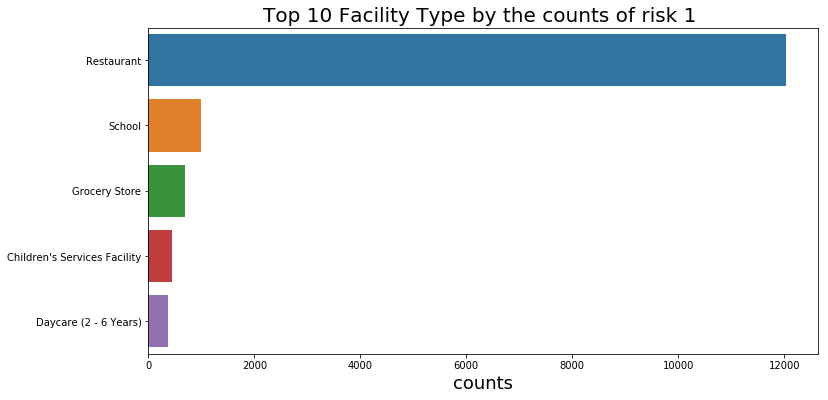

In [304]:
plt.figure(figsize = (12,6))
ax = sns.barplot(x=x_1[0:5],y=x_1.index[0:5])
ax.set_title("Top 10 Facility Type by the counts of risk 1 ",size=20)
ax.set_xlabel('counts',size=18)
plt.show()

Below is an example code of the folium plugin we mainly wanted to use. It allows use to plot heatmaps on the map of Chicago with a slider for the time (in years). However 

In [ ]:
# df = data_risk1[['Latitude','Longitude','year']].groupby('year')['Latitude','Longitude'].agg(lambda x: list(x))
# to_plot = [[[row['Latitude'][k],row['Longitude'][k]] for k in range(len(row['Latitude'])) ] for index, row in df.iterrows() ]
# m= folium.Map(location= [41.6,-87.5],tiles='Stamen Toner', zoom_start=10)
# hm = plugins.HeatMapWithTime(
#     to_plot,
#     auto_play=True,
#     max_opacity=0.5,
#     display_index = True,
#     overlay=True
    
# )
# hm.add_to(m)
# m

In [371]:
folium_risk_1 = data_risk1.groupby(['Latitude','Longitude','DBA Name'])['index'].count().to_frame().reset_index()

coord = [folium_risk_1["Latitude"].mean(),folium_risk_1["Longitude"].mean()] 
m_risk1= folium.Map(location= coord,tiles='Stamen Toner', zoom_start=10)
coords = folium_risk_1[['Latitude', 'Longitude']].as_matrix()
m_risk1.add_child(plugins.HeatMap(coords, radius=15))
m_risk1

/home/red/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


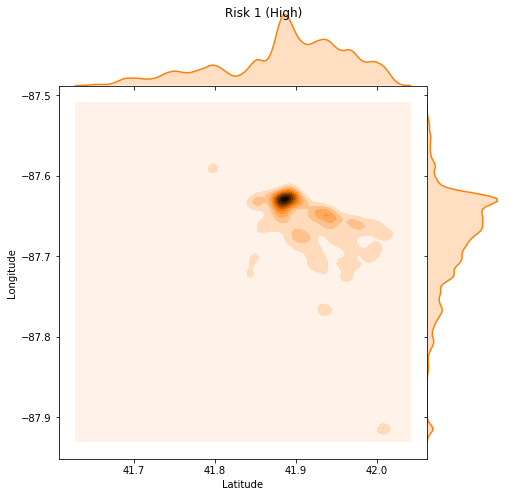

In [270]:
ax = sns.jointplot("Latitude", "Longitude", data=data_risk1, kind="kde", space=0, color= colors[0], height=7)
ax.fig.suptitle("Risk 1 (High)")
plt.show()

### Risk 2

We take a look at the distribution for the facility types for risk 2.

In [372]:
folium_risk_2 = data_risk2.groupby(['Latitude','Longitude','DBA Name'])['index'].count().to_frame().reset_index()

coord = [folium_risk_2["Latitude"].mean(),folium_risk_2["Longitude"].mean()] 
m_risk1= folium.Map(location= coord,tiles='Stamen Toner', zoom_start=10)
coords = folium_risk_2[['Latitude', 'Longitude']].as_matrix()
m_risk1.add_child(plugins.HeatMap(coords, radius=15))
m_risk1

/home/red/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [ ]:
ax = sns.jointplot("Latitude", "Longitude", data=data_risk2, kind="kde", space=0, color= colors[1], height=7)
ax.fig.suptitle("Risk 2 (Medium)")
plt.show()

### Risk 3

We take a look at the distribution for the facility types for risk 3.

We plot the distribution for the 4 most common establishment type (from 'Restaurant' to 'Mobile Prepared Food Vendor').

In [373]:
folium_risk_3 = data_risk3.groupby(['Latitude','Longitude','DBA Name'])['index'].count().to_frame().reset_index()

coord = [folium_risk_3["Latitude"].mean(),folium_risk_3["Longitude"].mean()] 
m_risk1= folium.Map(location= coord,tiles='Stamen Toner', zoom_start=10)
coords = folium_risk_3[['Latitude', 'Longitude']].as_matrix()
m_risk1.add_child(plugins.HeatMap(coords, radius=15))
m_risk1

/home/red/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [ ]:

ax = sns.jointplot("Latitude", "Longitude", data=data_risk3, kind="kde", space=0, color= colors[2], height=7)
ax.fig.suptitle("Risk 3 (Low)")
plt.show()

## Deeper study of the risk using heat maps

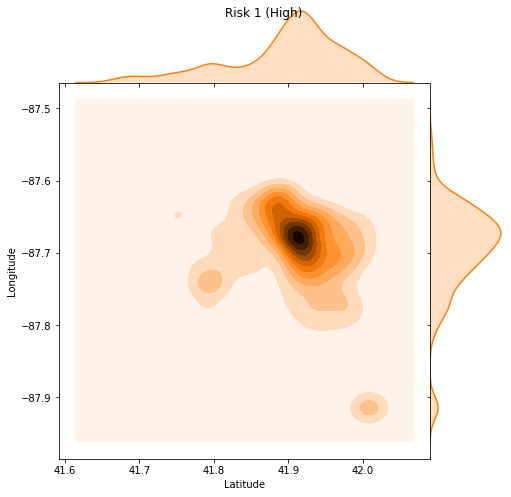

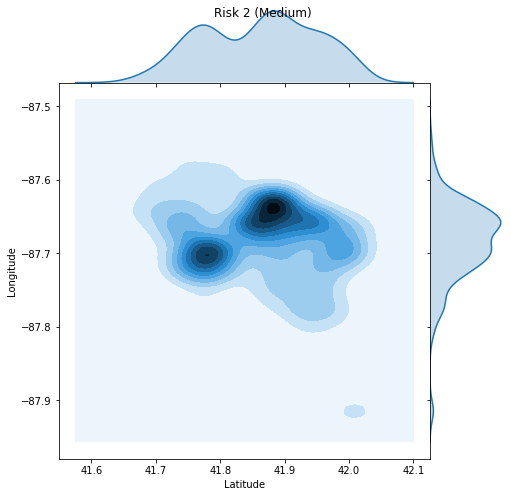

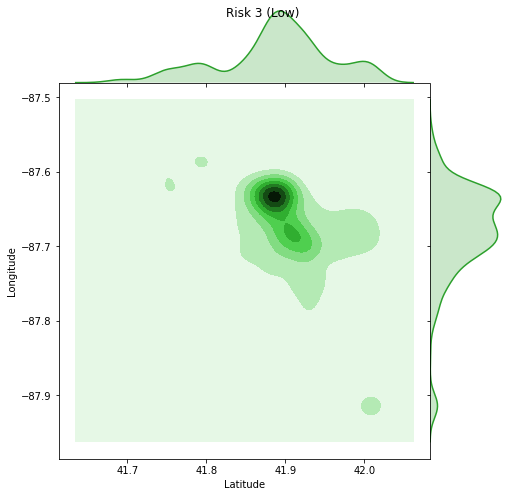

In [27]:
ax = sns.jointplot("Latitude", "Longitude", data=data_risk1[0:500], kind="kde", space=0, color= colors[0], height=7)
ax.fig.suptitle("Risk 1 (High)")
plt.show()

ax = sns.jointplot("Latitude", "Longitude", data=data_risk2[0:500], kind="kde", space=0, color= colors[1], height=7)
ax.fig.suptitle("Risk 2 (Medium)")
plt.show()

ax = sns.jointplot("Latitude", "Longitude", data=data_risk3[0:500], kind="kde", space=0, color= colors[2], height=7)
ax.fig.suptitle("Risk 3 (Low)")
plt.show()